# U-Net

The first approach would be training a U-Net model and use the Encoder as a classifier.

In [ ]:
! pip install torch
! pip install torchvision
! pip install pandas
! pip install tqdm
! pip install matplotlib
! pip install psutil
! pip install segmentation-models-pytorch
! pip install wandb

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


True

# Prepare Datasets

In [3]:
from dataset import SegmentationDataset, SegmentationDatasetWithRandomCrops
from torch.utils.data import DataLoader, random_split, ConcatDataset
import os
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize
import torch
import numpy as np

train_image_path = './FIVES/train/Original'
train_label_path = './FIVES/train/GroundTruth'
test_image_path = './FIVES/test/Original'
test_label_path = './FIVES/test/GroundTruth'

# Define transformations for images
image_transform = Compose([
    Grayscale(num_output_channels=1),  # Convert the image to grayscale
    Resize((512, 512)),                # Resize images to 512x512
    ToTensor()                         # Convert the image to a PyTorch tensor
])

# Define transformations for labels, if needed
label_transform = Compose([
    Resize((512, 512)),  # Resize labels to 512x512
    ToTensor()           # Convert label to a tensor
])

random_crop_image_transform = Compose([
    Grayscale(num_output_channels=1),
    ToTensor()
])
random_crop_label_transform = Compose([ToTensor()])

random_crop_dataset = SegmentationDatasetWithRandomCrops(
    train_image_path, 
    train_label_path, 
    random_crop_image_transform, 
    random_crop_label_transform
)
subset_size = int(0.3 * len(random_crop_dataset))
subset_indices = np.random.choice(len(random_crop_dataset), subset_size, replace=False)
random_crop_dataset = torch.utils.data.Subset(random_crop_dataset, subset_indices)

dataset = SegmentationDataset(
    train_image_path, 
    train_label_path, 
    image_transform, 
    label_transform
)
testset = SegmentationDataset(
    test_image_path, 
    test_label_path, 
    image_transform, 
    label_transform
)

# Prepare DataLoader
train_size, val_size = int(0.9 * len(dataset)), int(0.1 * len(dataset) + 1)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = ConcatDataset([train_dataset, random_crop_dataset])
print(f'Number of samples in the training set: {len(train_dataset)}, validation set: {len(val_dataset)}')
print(f'Number of samples in the test set: {len(testset)}')

trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
validationloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=8)


Number of samples in the training set: 712, validation set: 60
Number of samples in the test set: 200


# Visualize Dataset

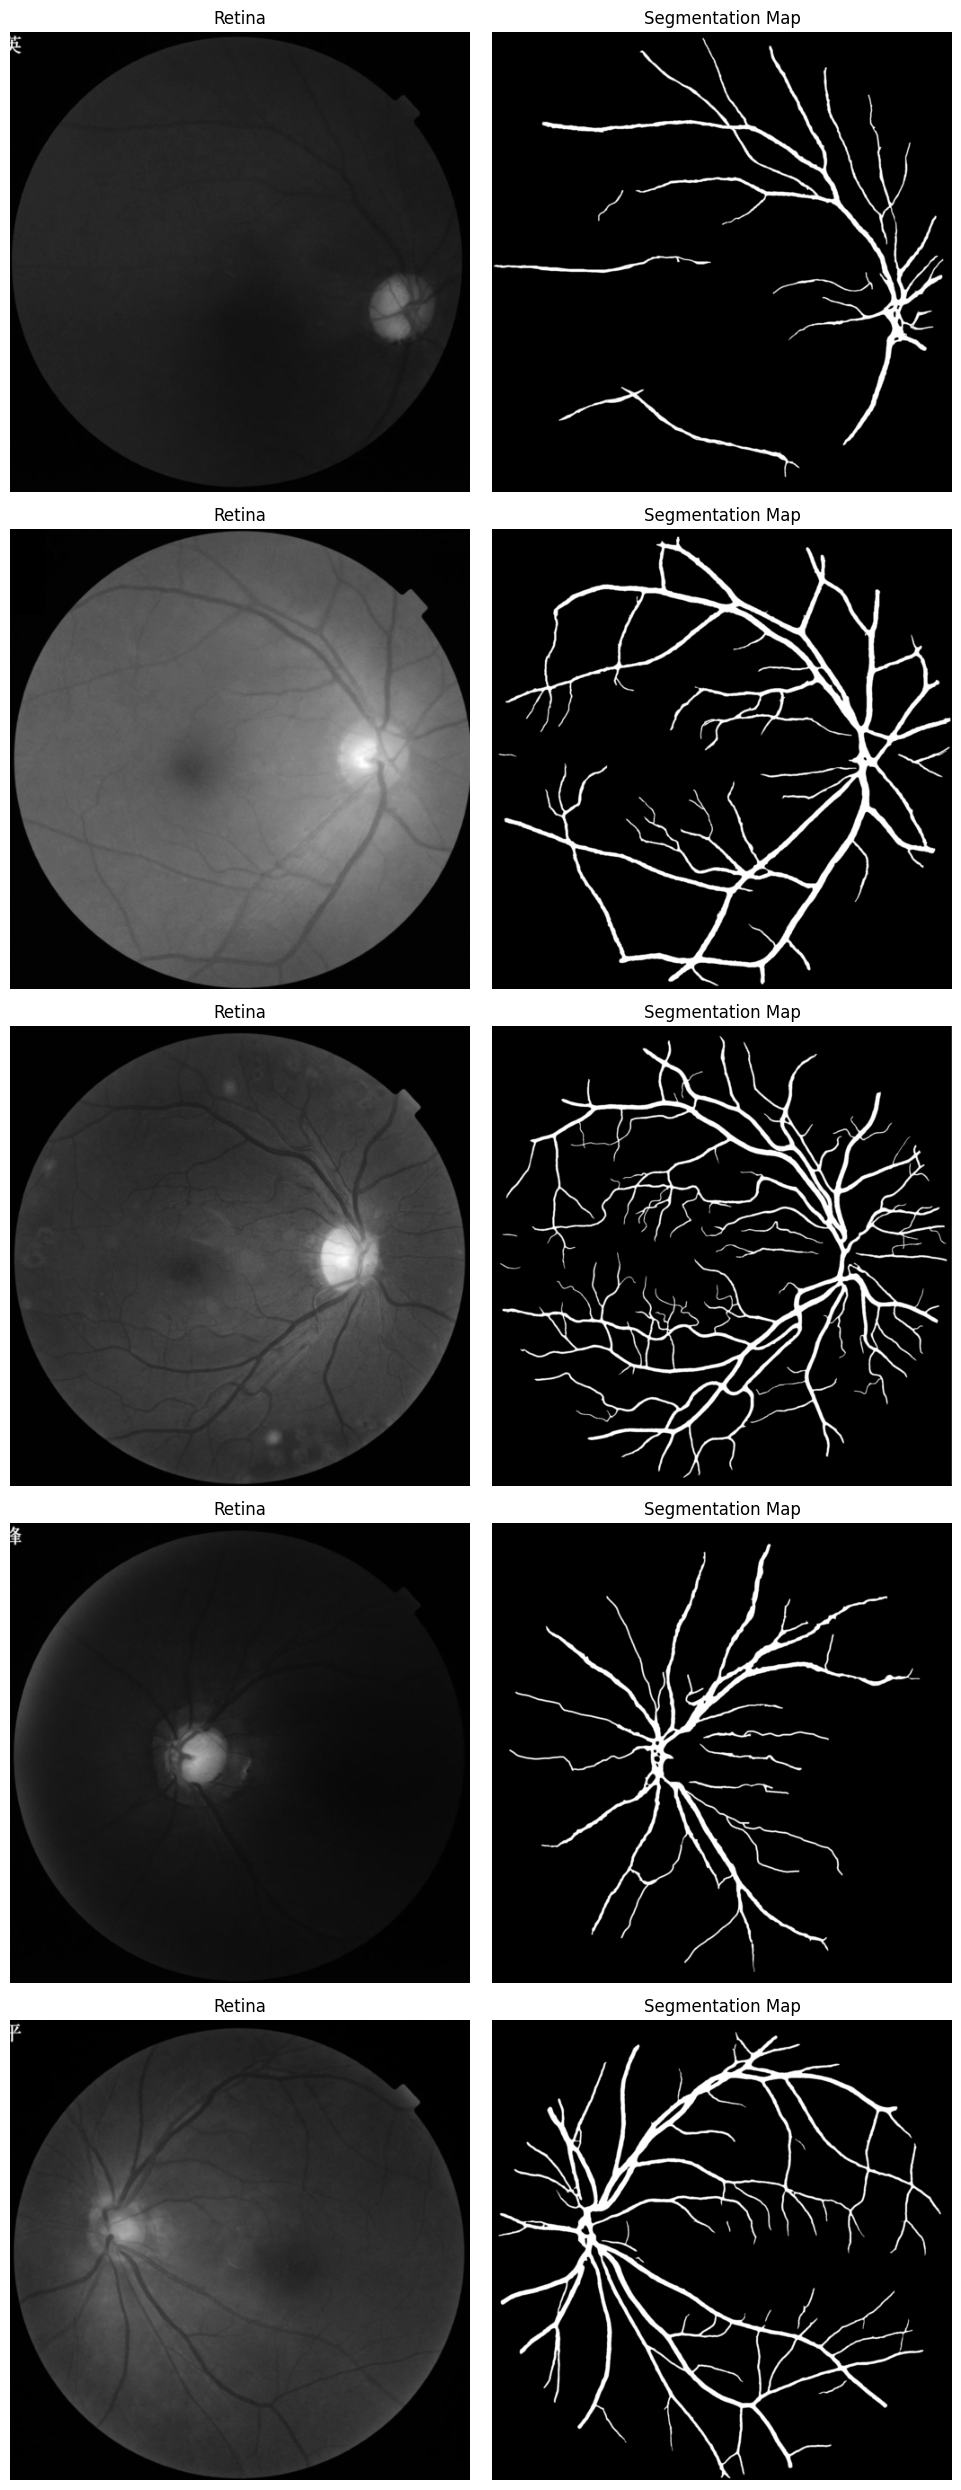

In [2]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=5):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 5))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert from PyTorch tensor format and channel first to channel last
        lbl = labels[i].numpy().squeeze()            # Remove extra dimensions
        
        if num_images == 1:
            ax_img = axs[0]
            ax_lbl = axs[1]
        else:
            ax_img = axs[i, 0]
            ax_lbl = axs[i, 1]
        
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title('Fundus')
        ax_img.axis('off')
        
        ax_lbl.imshow(lbl, cmap='gray')
        ax_lbl.set_title('Segmentation Map')
        ax_lbl.axis('off')

    plt.tight_layout()
    plt.show()

show_images(*zip(*[dataset[i] for i in range(5)]))

# Training

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10, Loss: 0.3702
Epoch 1, Batch 20, Loss: 0.2344
Epoch 1, Batch 30, Loss: 0.1828
Epoch 1, Batch 40, Loss: 0.1585
Epoch 1, Batch 50, Loss: 0.1553
Epoch 1, Batch 60, Loss: 0.1351
Epoch 1, Batch 70, Loss: 0.1218
Epoch 1, Batch 80, Loss: 0.1197
Epoch 1, Train Loss: 0.1769


wandb: WARNING Cache size exceeded. Attempting to reclaim space...


Epoch 1, Validation Loss: 0.0911
Epoch 2, Batch 10, Loss: 0.1046
Epoch 2, Batch 20, Loss: 0.1138
Epoch 2, Batch 30, Loss: 0.1145
Epoch 2, Batch 40, Loss: 0.1113
Epoch 2, Batch 50, Loss: 0.0989
Epoch 2, Batch 60, Loss: 0.0995
Epoch 2, Batch 70, Loss: 0.0866
Epoch 2, Batch 80, Loss: 0.0912
Epoch 2, Train Loss: 0.1013
Epoch 2, Validation Loss: 0.0779
Epoch 3, Batch 10, Loss: 0.0844
Epoch 3, Batch 20, Loss: 0.0875
Epoch 3, Batch 30, Loss: 0.0911
Epoch 3, Batch 40, Loss: 0.0921
Epoch 3, Batch 50, Loss: 0.0909
Epoch 3, Batch 60, Loss: 0.0928
Epoch 3, Batch 70, Loss: 0.0888
Epoch 3, Batch 80, Loss: 0.0884
Epoch 3, Train Loss: 0.0893
Epoch 3, Validation Loss: 0.0980
Epoch 4, Batch 10, Loss: 0.0825
Epoch 4, Batch 20, Loss: 0.0921
Epoch 4, Batch 30, Loss: 0.0946
Epoch 4, Batch 40, Loss: 0.0853
Epoch 4, Batch 50, Loss: 0.0868
Epoch 4, Batch 60, Loss: 0.0895
Epoch 4, Batch 70, Loss: 0.0777
Epoch 4, Batch 80, Loss: 0.0838
Epoch 4, Train Loss: 0.0855
Epoch 4, Validation Loss: 0.0837
Epoch 5, Batch 1

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/loss,█▃▂▂▂▁▁▁▁▁
validation/loss,▆▄█▅▂█▁▁▂▁
epoch,10
test/accuracy,0.96093
test/dice_score,0.59831


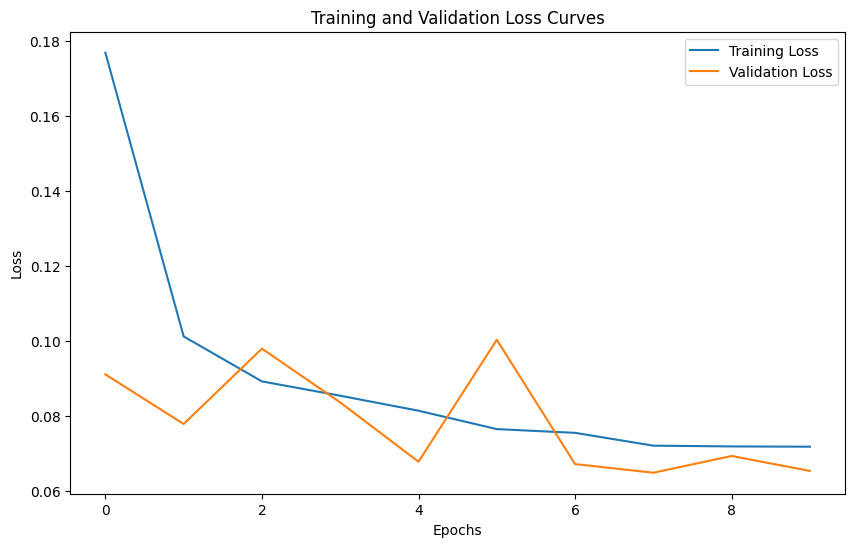

In [3]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch
from segmentation_util import model_pipeline
import matplotlib.pyplot as plt

config = {
    'model': 'Unet-resnet152-512x512-augmented-with-random-crops',
    'learnnig_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'BCEWithLogitsLoss',
}

model = smp.Unet('resnet152', in_channels=1, classes=1)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=config['learnnig_rate'])
#criterion = smp.losses.DiceLoss(mode='binary')
criterion = nn.BCEWithLogitsLoss()

model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, 
                                                 criterion=criterion, 
                                                 optimizer=optimizer,
                                                 project='fundus-segmentation',
                                                 model_name=config['model'],
                                                 device=device, 
                                                 config=config)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [5]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet('resnet152', in_channels=1, classes=1)
model.load_state_dict(torch.load('./models/Unet-resnet152-512x512-augmented-with-random-crops_epoch10.pth'))

<All keys matched successfully>

# Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


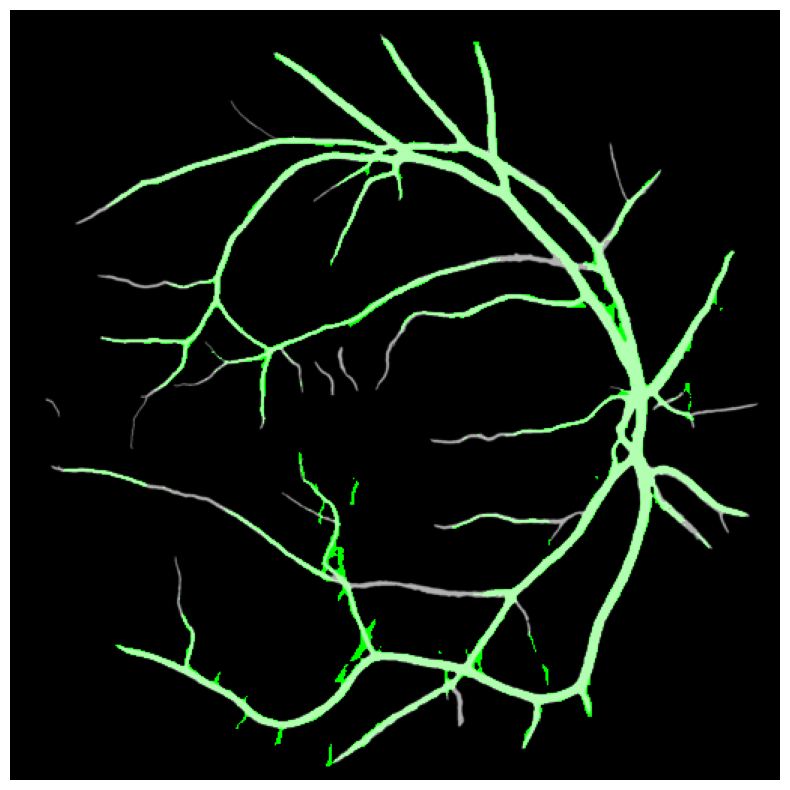

In [7]:
from segmentation_util import evaluate_model, predict
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_overlay(model, data, device):
    prediction = predict(model, data[0], device)
    image = data[1].cpu().numpy().squeeze()
    image = np.stack([image, image, image], axis=-1)
    overlay = np.zeros_like(image)
    overlay[prediction.cpu().numpy().squeeze(0) == 1] = [0, 255, 0]
    combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(combined, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
show_overlay(model, train_dataset[1], device)
# show_images(*zip(*[train_dataset[i] for i in range(5)]))